
# GPU - Accelerated Linear Algebra in Python

Wednesday, 29 May 2024

https://eurocc.cyi.ac.cy/intermediate-level-programming-for-hpc-programming-using-python-training-event-2024/

*   CUDA (Compute Unified Device Architecture) is a parallel computing platform and
application programming interface (API) model created by NVIDIA that allows developers to use NVIDIA GPUs for general-purpose processing.
*   CuPy allows Python users to achieve GPU acceleration with minimal code changes, leveraging familiar NumPy-like syntax.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Your runtime has 13.6 gigabytes of available RAM

Wed May 29 10:26:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              31W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------

### NVIDIA GPU Information

- **GPU Details:** The system uses an NVIDIA Tesla T4 GPU, which is not running in persistence mode and is currently utilizing a minimal 9W of its 70W power capacity.
- **Memory and Utilization:** The GPU has 15.36GB of memory available, with 0% utilization at the moment, indicating no active processes using the GPU.
- **System Information:** The system is operating with NVIDIA driver version 535.104.05 and CUDA version 12.2, which are essential for running GPU-accelerated computations.

# Import Libraries

In [ ]:
import numpy as np
import time

In [ ]:
import os
# Get the number of available processors
num_processors = os.cpu_count()
# Print the number of processors
print(f"Number of available processors: {num_processors}")

Number of available processors: 2


In [ ]:
import cupy as cp

# Ensure the CUDA device is properly synchronized before fetching memory info
cp.cuda.runtime.deviceSynchronize()
device = cp.cuda.Device(0)  # Select the first GPU device

# Retrieve the total and free memory available on the GPU
free_memory, total_memory = cp.cuda.runtime.memGetInfo()

# Convert memory information from bytes to gigabytes for clarity
total_memory_gb = total_memory / (1024 ** 3)
free_memory_gb = free_memory / (1024 ** 3)

# Print both the total and free GPU memory to verify the values
print(f"Total GPU Memory: {total_memory_gb:.2f} GB")
print(f"Free GPU Memory: {free_memory_gb:.2f} GB")

Total GPU Memory: 14.75 GB
Free GPU Memory: 14.65 GB


# Matrix Multiplication

**Input:** $N \in \mathbb{Z}^+$  
*Dimension of the matrices*

- $A \gets \text{random matrix of size } N \times N$
- $B \gets \text{random matrix of size } N \times N$
- $T \gets 0$  
   *Initialize total time*

**For** $i \in \{1, 2, \dots, 10\}$:
   - $t_{\text{start}} \gets \text{current time}$
   - $C \gets A \times B$  
      *Matrix multiplication*
   - $t_{\text{end}} \gets \text{current time}$
   - $T \gets T + (t_{\text{end}} - t_{\text{start}})$


$\text{average time} \gets T / 10$


In [ ]:
# Matrix size
N = 2_000

In [ ]:
# Create matrices using NumPy
A_np = np.random.rand(N, N)
B_np = np.random.rand(N, N)
np.dot(A_np, B_np) # avoid initial overheads

# Measure NumPy time for matrix multiplication
start_time_np = time.time()
for i in range(10):
  C_np = np.dot(A_np, B_np)
  print("Benchmark:",i+1)
numpy_time = (time.time() - start_time_np)/10

print(f"NumPy Time: {numpy_time:.6f} seconds")

Benchmark: 1
Benchmark: 2
Benchmark: 3
Benchmark: 4
Benchmark: 5
Benchmark: 6
Benchmark: 7
Benchmark: 8
Benchmark: 9
Benchmark: 10
NumPy Time: 0.287114 seconds


In [ ]:
# Convert NumPy arrays to CuPy arrays
A_cp = cp.asarray(A_np)
B_cp = cp.asarray(B_np)
cp.dot(A_cp, B_cp) # avoid initial overheads

# Measure CuPy time for matrix multiplication
start_time_cp = time.time()
for i in range(10):
  C_cp = cp.dot(A_cp, B_cp)
  print("Benchmark:",i+1)
cupy_time = (time.time() - start_time_cp)/10

print(f"CuPy Time: {cupy_time:.6f} seconds")

Benchmark: 1
Benchmark: 2
Benchmark: 3
Benchmark: 4
Benchmark: 5
Benchmark: 6
Benchmark: 7
Benchmark: 8
Benchmark: 9
Benchmark: 10
CuPy Time: 0.000837 seconds


In [ ]:
print(f"NumPy/CuPy Time: {numpy_time/cupy_time:.6f}")

NumPy/CuPy Time: 342.845125


...run this with $N=2,000$...

- **Optimized Libraries**: CuPy utilizes CUDA and highly optimized GPU libraries (like cuBLAS) for mathematical operations, leading to more efficient execution compared to CPU-bound operations in NumPy.
- **Multiple threads** simultaneously process different portions of data, performing partial reductions in parallel.
- **Memory Bandwidth**: GPUs have higher memory bandwidth compared to CPUs, enabling faster data transfer rates and reducing the time spent on reading and writing large matrices.

# Element-wise addition

In [ ]:
# Size of the vectors
N = 1_000

In [ ]:
# Number of iterations for averaging the results
num_iterations = 10

# Create arrays with NumPy and CuPy
A_np = np.random.rand(N)
B_np = np.random.rand(N)
A_cp = cp.asarray(A_np)
B_cp = cp.asarray(B_np)

# Initialize timers
numpy_total_time = 0
cupy_total_time = 0

# Warm up to ensure GPU is initialized
# cp.add(cp.asarray(np.random.rand(N)), cp.asarray(np.random.rand(N)))

for _ in range(num_iterations):
    # Time NumPy operation
    start_np = time.time()
    C_np = A_np + B_np
    numpy_time = time.time() - start_np
    numpy_total_time += numpy_time

    # Time CuPy operation
    start_cp = time.time()
    C_cp = A_cp + B_cp
    cp.cuda.Device().synchronize()  # Ensure all operations are complete
    cupy_time = time.time() - start_cp
    cupy_total_time += cupy_time

# Compute average times
average_numpy_time = numpy_total_time / num_iterations
average_cupy_time = cupy_total_time / num_iterations

print(f"Average NumPy Element-wise Addition Time: {average_numpy_time:.6f} seconds")
print(f"Average CuPy Element-wise Addition Time: {average_cupy_time:.6f} seconds")
print(f"NumPy/CuPy Time: {average_numpy_time/average_cupy_time:.6f}")

Average NumPy Element-wise Addition Time: 0.000009 seconds
Average CuPy Element-wise Addition Time: 0.000189 seconds
NumPy/CuPy Time: 0.046845


...run again for $N=1000$...

### Why NumPy is Faster for Small $N$

- **GPU Overhead:** Initializing and synchronizing the GPU incurs overhead that can outweigh the benefits of parallel processing for small data sizes.
- **Memory Transfer:** Transferring data between CPU and GPU memory introduces latency that is significant when dealing with small arrays, making CPU operations faster.

*To fully leverage GPU performance, send large batches of data to minimize overhead and maximize parallel processing efficiency.*

In [ ]:
N=10
A_np = np.random.rand(N)
A_cp = cp.asarray(A_np)
cp.asarray(A_cp)

array([0.57825197, 0.03214955, 0.08726671, 0.3660074 , 0.14379972,
       0.50778563, 0.61231925, 0.42992299, 0.02151465, 0.7966884 ])

# SolveBak

**The SolveBak Algorithm**

**Input**: $\mathbf{X}$, $\mathbf{y}$

**Output**: $\mathbf{a}$

1. Initialize $\mathbf{a} = a_{j \in \{1,2,\dots,n\}} = \mathbf{0}_n$ (initial guess)
2. Compute $\mathbf{e} = \mathbf{y} - \mathbf{X} \times \mathbf{a}$

3. For $i \in \{1,2,\dots,N\}$:
   1. For $j \in \{1,2,\dots,n\}$:
      1. $da = \frac{\langle \mathbf{X}_j, \mathbf{e} \rangle}{\langle \mathbf{X}_j, \mathbf{X}_j \rangle}$
      2. Update $\mathbf{e} \leftarrow \mathbf{e} - \mathbf{X}_j \times da$
      3. Update $a_j \leftarrow a_j + da$

4. Return $\mathbf{a}$ such that $\mathbf{X} \times \mathbf{a} = \mathbf{y}$


view more on https://arxiv.org/pdf/2104.12570

---
## Initialize variables
---

In [ ]:
obs=100_000
vars=1_000
ITERS = 10

## SolveBak with *NumPy*

In [ ]:
x=np.random.rand(obs,vars)-1/2
a=np.random.rand(vars)-1/2
y=np.dot(x,a)

x_x=np.sum(x*x,axis=0)
aa=np.zeros(vars)
e=np.copy(y)
t1=time.time()
for i in range(ITERS):
    for j in range(vars):
        da=np.dot(x[:,j],e)/x_x[j]
        e-=da*x[:,j]
        aa[j]+=da
t2=time.time()

numpy_time = t2-t1
print(f"NumPy time: {numpy_time:.6f}- Error: {np.mean(np.abs(a-aa)):.3E}")

NumPy time: 13.085524- Error: 2.592E-14


## SolveBak with *CuPy*

In [ ]:
x=cp.random.rand(obs,vars)-1/2
a=cp.random.rand(vars)-1/2
y=cp.dot(x,a)

aa = cp.zeros(vars)
x_x=cp.sum(x*x,axis=0)
e = cp.copy(y)
t1 = time.time()
for i in range(ITERS):
    for j in range(vars):
        da = cp.dot(x[:, j], e) / x_x[j]
        e -= da * x[:, j]
        aa[j] += da
t2 = time.time()

cupy_time = t2-t1
print(f"CuPy time: {cupy_time:.6f} - Error: {cp.mean(cp.abs(cp.asarray(a)-aa)):.3E}")

CuPy time: 2.783537 - Error: 2.990E-14


In [ ]:
print(f"NumPy/CuPy Time: {numpy_time/cupy_time:.6f}")

NumPy/CuPy Time: 4.701041


# SolveBak with batches

**The Parallel HPSCDP Solver**

**Input**: $\mathbf{X}$, $\mathbf{y}$

**Output**: $\mathbf{a}$

1. Initialize $\mathbf{a} = \mathbf{0}_n$ (or an initial guess).
2. Compute $\mathbf{e} = \mathbf{y} - \mathbf{X} \times \mathbf{a}$.

3. For $i \in \{1,2,\dots,N\}$:
   1. Set $\mathbf{a_{\text{prev}}} \leftarrow \mathbf{a}$.
   2. For $j \in \{1, \text{thr}+1, 2\text{thr}+1, \dots, n-\text{thr}+1\}$:
      1. For $k \in \{j, j+1, \dots, j+\text{thr}-1\}$ do in parallel:
         1. Update $a_k \leftarrow a_k + \frac{\langle \mathbf{X}_k, \mathbf{e} \rangle}{\langle \mathbf{X}_k, \mathbf{X}_k \rangle}$.
      2. Update $\mathbf{e} \leftarrow \mathbf{e} - \mathbf{X}_{jj} \times de$,
      .

4. Return $\mathbf{a}$ such that $\mathbf{X} \times \mathbf{a} = \mathbf{y}$.

---
## Initialize variables
---

In [ ]:
obs=100_000
vars=1_000
ITERS = 10
BATCH = 100

## SolveBak with *NumPy* in BATCHES

In [ ]:
x=np.random.rand(obs,vars)-1/2
a=np.random.rand(vars)-1/2
y=np.dot(x,a)

x_x=np.sum(x*x,axis=0)
aa=np.zeros(vars)
e=np.copy(y)
t1=time.time()
for i in range(ITERS):
    for j in range(0,vars,BATCH):
        # here we apply dot product for matrices instead of vectors
        da = np.dot(x[:, j:j+BATCH].T, e) / x_x[j:j+BATCH]
        e -= np.sum(da * x[:, j:j+BATCH], axis=1)
        aa[j:j+BATCH] += da

t2=time.time()
numpy_time = t2-t1
print(f"NumPy time: {numpy_time:.6f}- Error: {np.mean(np.abs(a-aa)):.3E}")

NumPy time: 0.005257- Error: 9.576E-04


## SolveBak with *CuPy* in BATCHES

In [ ]:
x=cp.random.rand(obs,vars)-1/2
a=cp.random.rand(vars)-1/2
y=cp.dot(x,a)

aa = cp.zeros(vars)
x_x=cp.sum(x*x,axis=0)
e = cp.copy(y)
t1 = time.time()
for i in range(ITERS):
    for j in range(0,vars,BATCH):
        da = cp.dot(x[:, j:j+BATCH].T, e) / x_x[j:j+BATCH]
        e -= cp.sum(da * x[:, j:j+BATCH], axis=1)
        aa[j:j+BATCH] += da
t2=time.time()

cupy_time = t2-t1
print(f"CuPy time: {cupy_time:.6f} - Error: {cp.mean(cp.abs(cp.asarray(a)-aa)):.3E}")

CuPy time: 0.179903 - Error: 8.580E-04


In [ ]:
print(f"NumPy/CuPy Time: {numpy_time/cupy_time:.6f}")

NumPy/CuPy Time: 0.029219


...run again with small obs...

CuPy is faster than NumPy when using the second algorithm with batches:

1. **Parallel Batch Processing:** CuPy leverages the GPU's parallel processing capabilities, allowing multiple batches to be processed concurrently. This significantly speeds up the reduction operations within each batch, compared to the sequential processing on a CPU.

2. **Optimized Memory Usage:** GPUs have higher memory bandwidth and can handle large data transfers more efficiently.

3. **Batch Size Optimization**: Larger batch sizes can be handled more efficiently on GPUs, fully utilizing their massive parallel architecture and reducing overhead.

*Batch size should be less than the available GPU RAM to avoid memory overflow; use MPI for larger data sizes to distribute computation across multiple GPUs or nodes.*

# Artificial Neural Networks

$$y_i \cong \sum\limits_{k=1}^{N}{{{v}_{k}}}\sigma \left( \sum\limits_{j=1}^{n}{{{w}_{jk}}{{x}_{ij}}}+{{b}_{k}} \right)+{{b}_{0}}$$

https://link.springer.com/content/pdf/10.1007/s00477-023-02407-2.pdf

In [ ]:
import datetime
import numpy as np
import time
import matplotlib.pyplot as plt

## With NumPy

In [ ]:
obs = 100_000
vars = 10

### Prepare the training and testing sets

In [ ]:
x=np.random.rand(obs,vars)-1/2
y = np.sin(np.sum(x,axis=1))/2

xt=np.random.rand(obs,vars)-1/2
yt = np.sin(np.sum(xt,axis=1))/2

### Define the number of neurons

In [ ]:
neurons = 1_000

In [ ]:
i_train = x.shape[0]
layer1 = np.zeros((i_train, neurons))
w_all = []
i_err = []

### Size of internal neurons' batch

In [ ]:
n_train_internal = x.shape[0]//neurons
n_train_internal

100

$$\mathbf{X}_k := (x_{ijk})_{i \in [m_k], j \in [n]}$$

$$\sigma \odot \Big(\big(\mathbf{X}_k \Big|\mathbf{1}\big) \times \mathbf{w}_k\Big) = \mathbf{y}_k$$

$$\big(\mathbf{X}_k \Big| \mathbf{1}\big) \times \mathbf{w}_k = \sigma^{-1} \odot (\mathbf{y}_k )$$

In [ ]:
yy = np.arctanh(y)

### Compute internal neurons weights

In [ ]:
print("Computing internal neurons' weights...")
t1=time.time()
for i in range(neurons):
    ii = np.random.permutation(x.shape[0])[:n_train_internal]
    try:
        aa = np.linalg.lstsq(x[ii],yy[ii], rcond=None)[0]
        w_all.append(aa)
        if i in range(0,neurons,neurons//10):
            sdt = datetime.datetime.now().strftime('%H:%M:%S.%f')[:-3]
            print(sdt,"Computing weights for neuron",i,"of",neurons)
    except Exception as ex:
        i_err.append(i)
        print("Error in neuron ", i, ":", ex)

t2=time.time()
numpy_time_inner = t2-t1
print(f"NumPy time: {numpy_time_inner:.6f}")

Computing internal neurons' weights...
11:09:03.365 Computing weights for neuron 0 of 1000
11:09:03.538 Computing weights for neuron 100 of 1000
11:09:03.719 Computing weights for neuron 200 of 1000
11:09:03.899 Computing weights for neuron 300 of 1000
11:09:04.085 Computing weights for neuron 400 of 1000
11:09:04.277 Computing weights for neuron 500 of 1000
11:09:04.460 Computing weights for neuron 600 of 1000
11:09:04.642 Computing weights for neuron 700 of 1000
11:09:04.820 Computing weights for neuron 800 of 1000
11:09:05.001 Computing weights for neuron 900 of 1000
NumPy time: 1.827874


### Formulate outer layer

In [ ]:
w_all = np.array(w_all)
w_all.shape
sdt = datetime.datetime.now().strftime('%H:%M:%S.%f')[:-3]
print(sdt,"Formulating Layers")
layer1 = np.tanh(np.dot(x, w_all.T))

11:09:07.586 Formulating Layers


$$\mathbf{\hat{X}} := \bigg[ \sigma \odot \Big(\big(\mathbf{X} \Big| \mathbf{1}\big)\times \mathbf{w} \Big) \bigg| \mathbf{1}\bigg]$$

$$ \mathbf{\hat{X}} \times \mathbf{v} = \mathbf{y}$$

### Solve for outter layer's weights

In [ ]:
t1=time.time()
# V = np.linalg.lstsq(layer1,y,rcond=-1)[0]
V = np.linalg.solve(layer1.T@layer1,layer1.T@y)
t2=time.time()
numpy_time_outer = t2-t1
print(f"NumPy time: {numpy_time_outer:.6f}")

NumPy time: 3.085749


### Check accuracy

In [ ]:
pred = np.dot(layer1,V)
np.corrcoef(pred,y)[0,1]

0.9999978851393453

In [ ]:
layer1t = np.tanh(np.dot(xt, w_all.T))
predt = np.dot(layer1t,V)
np.corrcoef(predt,yt)[0,1]

0.9999978173657291

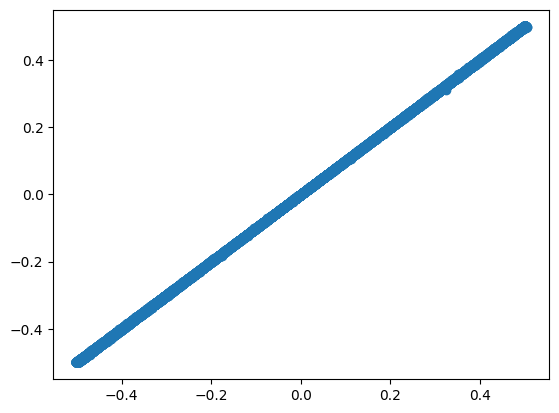

In [ ]:
plt.scatter(predt,yt)

## With CuPy

In [ ]:
import cupy as cp

### Transfer data to GPU

In [ ]:
x = cp.array(x)
y = cp.array(y)
xt = cp.array(xt)
yt = cp.array(yt)

### Initialize variables

In [ ]:
layer1 = cp.zeros((i_train, neurons))
w_all = []
i_err = []
ii_all = []

In [ ]:
yy = cp.arctanh(y)

### Compute internal neurons' weights

In [ ]:
t1=time.time()
for i in range(neurons):
    ii = np.random.permutation(x.shape[0])[:n_train_internal]
    ii_all.append(ii)
    try:
        aa = cp.linalg.lstsq(x[ii],yy[ii], rcond=None)[0]
        w_all.append(aa)
        if i in range(0,neurons,neurons//10):
            sdt = datetime.datetime.now().strftime('%H:%M:%S.%f')[:-3]
            print(sdt,"Computing weights for neuron",i,"of",neurons)
    except Exception as ex:
        i_err.append(i)
        print("Error in neuron ", i, ":", ex)

t2=time.time()
cupy_time_inner = t2-t1
print(f"CuPy time: {cupy_time_inner:.6f}")

11:09:59.873 Computing weights for neuron 0 of 1000
11:10:00.502 Computing weights for neuron 100 of 1000
11:10:01.118 Computing weights for neuron 200 of 1000
11:10:01.734 Computing weights for neuron 300 of 1000
11:10:02.708 Computing weights for neuron 400 of 1000
11:10:03.720 Computing weights for neuron 500 of 1000
11:10:04.306 Computing weights for neuron 600 of 1000
11:10:04.778 Computing weights for neuron 700 of 1000
11:10:05.249 Computing weights for neuron 800 of 1000
11:10:05.739 Computing weights for neuron 900 of 1000
CuPy time: 17.150124


In [ ]:
w_all = cp.array(w_all)
w_all.shape
sdt = datetime.datetime.now().strftime('%H:%M:%S.%f')[:-3]
print(sdt,"Formulating Layers")
layer1 = cp.tanh(cp.dot(x, w_all.T))

11:10:13.617 Formulating Layers


### Solve for outter layer's weights

In [ ]:
t1=time.time()
# V = cp.linalg.lstsq(layer1,y,rcond=-1)[0]
V = cp.linalg.solve(layer1.T@layer1,layer1.T@y)
t2=time.time()
cupy_time_outer = t2-t1
print(f"CuPy time: {cupy_time_outer:.6f}")

CuPy time: 1.269419


### Check the accuracy

In [ ]:
pred = cp.dot(layer1,V)
cp.corrcoef(pred,y)[0,1]

array(0.9999495)

In [ ]:
layer1t = cp.tanh(cp.dot(xt, w_all.T))
predt = cp.dot(layer1t,V)
cp.corrcoef(predt,yt)[0,1]

array(0.99994792)

## Comparison

In [ ]:
print(f"NumPy/CuPy Time - Inner Layer: {numpy_time_inner/cupy_time_inner:.6f}")

NumPy/CuPy Time - Inner Layer: 0.106581


In [ ]:
print(f"NumPy/CuPy Time - Output Layer: {numpy_time_outer/cupy_time_outer:.6f}")

NumPy/CuPy Time - Output Layer: 2.430836


### Conclusions

- **Matrix Multiplication Performance:** CuPy significantly outperforms NumPy in matrix multiplication, leveraging GPU parallelism for faster computations.
- **Element-wise Operations:** For large arrays, CuPy is much faster than NumPy due to efficient parallel processing and higher memory bandwidth of GPUs.
- **Batch Processing Efficiency:** CuPy handles large batches more effectively, fully utilizing GPU capabilities and reducing overhead, but batch sizes must be within available GPU RAM to avoid memory overflow.
- **Optimization Strategy:** For handling larger data sizes exceeding GPU memory, use MPI to distribute computations across multiple GPUs or nodes for better performance and efficiency.